In [20]:
%pip -q install transformer_lens
%pip -q install circuitsvis

In [21]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import einops
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px

In [22]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

## Dataset and Model

In [24]:
from itertools import product

def generate_xor_dataset(bit_length=1, n_samples=None, device='cpu', seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
    if n_samples is None:
        all_pairs = list(product([0, 1], repeat=2 * bit_length))
        #random.shuffle(all_pairs)
        inputs = torch.tensor(all_pairs, dtype=torch.long, device=device)
    else:
        inputs = torch.randint(
            0, 2, size=(n_samples, 2 * bit_length), dtype=torch.long, device=device
        )

    a = inputs[:, :bit_length]
    b = inputs[:, bit_length:]
    targets = torch.bitwise_xor(a, b)

    return inputs, targets
seed = 598
bit_length = 7
dataset, labels = generate_xor_dataset(bit_length=bit_length, device=device, seed=seed)

In [25]:
cfg = HookedTransformerConfig(
        n_layers=1,
        n_heads=2,
        d_model=64,
        d_head=32,
        d_mlp=256,
        act_fn="relu",
        normalization_type=None,
        d_vocab=2,
        d_vocab_out=2,
        n_ctx=14,
        init_weights=True,
        device=device,
        seed=999,
    )

In [26]:
checkpoint = torch.load("/content/grokking_xor_7_bits.pth", map_location=device, weights_only=False)

In [27]:
model = HookedTransformer(cfg)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [28]:
model.eval()

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0): TransformerBlock(
      (ln1): Identity()
      (ln2): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

In [29]:
def to_tokens(inputs):
    """inputs: (B, 8) with {0,1} ints. Returns long tensor on device."""
    if not torch.is_tensor(inputs):
        inputs = torch.tensor(inputs, dtype=torch.long)
    return inputs.to(device)

# Given your existing generator:
# dataset, labels = generate_xor_dataset(bit_length=4, device=device, seed=seed)
tokens = to_tokens(dataset)                     # (B, 8)
B, L = tokens.shape
assert L == 14, "This code assumes 8-bit inputs."

# xor labels per pair (i, i+4)
xor_labels = torch.bitwise_xor(tokens[:, :7], tokens[:, 7:])  # (B, 4)

# Positions we treat as 'xi' readout sites; edit if your training layout differs
xi_pos = [7, 8, 9, 10, 11, 12, 13]  # positions corresponding to x0..x3
assert len(xi_pos) == 7

# Map each xi_pos to its source pair (i, i+4)
src_pairs = {p: (p-7, p) for p in xi_pos}

In [30]:
print(src_pairs)

{7: (0, 7), 8: (1, 8), 9: (2, 9), 10: (3, 10), 11: (4, 11), 12: (5, 12), 13: (6, 13)}


In [31]:
print(tokens[0])
print(xor_labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 1, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0]])


In [32]:
logits, cache = model.run_with_cache(tokens)
for param_name, param in cache.items():
    print(param_name, param.shape)

hook_embed torch.Size([16384, 14, 64])
hook_pos_embed torch.Size([16384, 14, 64])
blocks.0.hook_resid_pre torch.Size([16384, 14, 64])
blocks.0.attn.hook_q torch.Size([16384, 14, 2, 32])
blocks.0.attn.hook_k torch.Size([16384, 14, 2, 32])
blocks.0.attn.hook_v torch.Size([16384, 14, 2, 32])
blocks.0.attn.hook_attn_scores torch.Size([16384, 2, 14, 14])
blocks.0.attn.hook_pattern torch.Size([16384, 2, 14, 14])
blocks.0.attn.hook_z torch.Size([16384, 14, 2, 32])
blocks.0.hook_attn_out torch.Size([16384, 14, 64])
blocks.0.hook_resid_mid torch.Size([16384, 14, 64])
blocks.0.mlp.hook_pre torch.Size([16384, 14, 256])
blocks.0.mlp.hook_post torch.Size([16384, 14, 256])
blocks.0.hook_mlp_out torch.Size([16384, 14, 64])
blocks.0.hook_resid_post torch.Size([16384, 14, 64])


In [33]:
pattern = cache["pattern", 0, "attn"]
print(pattern.shape)

torch.Size([16384, 2, 14, 14])


torch.Size([16384, 2, 14, 14])


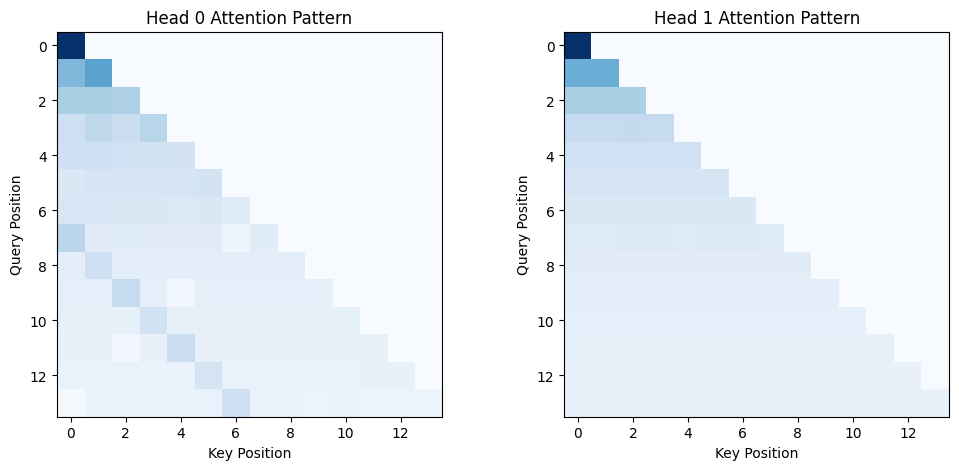

In [34]:
import matplotlib.pyplot as plt

# Get the attention pattern from layer 0
pattern = cache["blocks.0.attn.hook_pattern"]  # shape: (batch, n_heads, seq_len, seq_len)
print(pattern.shape)

batch_idx = 0
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for head in range(2):
    attn_matrix = pattern[batch_idx, head].cpu().numpy()  # (seq_len, seq_len)
    axes[head].imshow(attn_matrix, cmap='Blues')
    axes[head].set_title(f'Head {head} Attention Pattern')
    axes[head].set_xlabel('Key Position')
    axes[head].set_ylabel('Query Position')

In [35]:
# pattern: (B, H, L, L)
pattern = cache["blocks.0.attn.hook_pattern"].detach().cpu().numpy()
B, H, L, _ = pattern.shape
batch_idx = 0

for h in range(H):
    A = pattern[batch_idx, h]  # (L, L)
    imshow(
        A,
        xaxis="Key position",
        yaxis="Query position",
        title=f"Head {h} — Attention"
    )

In [36]:
# v_acts: (B, L, H, d_head) in TransformerLens
v_acts = cache["blocks.0.attn.hook_v"]
# Average ‖v‖ per (head, key-position): (H, L)
V_norm = v_acts.norm(dim=-1).mean(dim=0).permute(1, 0).detach().cpu().numpy()

for h in range(H):
    A    = pattern[batch_idx, h]                # (L, L)
    A_vw = A * V_norm[h][None, :]               # weight columns (keys)
    imshow(
        A_vw,
        xaxis="Key position",
        yaxis="Query position",
        title=f"Head {h} — Value-weighted attention"
    )

In [37]:
# Path patching with Head 1, donor’s (i, i+offset) keys and Zero Ablation of head 1 to verify it's importance

supervise_idxs = [7,8,9,10,11,12,13]
offset         = 7

head_idx = 1  # test Head 1 as suspected router
xi_pos   = supervise_idxs             # query positions we supervise

# ---- helpers ----------------------------------------------------------------
def xor_acc(logits, labels, supervise_idxs):
    """
    logits: (B, L, 2); labels: (B, 4) in {0,1}
    Computes accuracy only at supervise_idxs.
    """
    B = logits.size(0)
    sl = logits[:, supervise_idxs, :]
    pred = sl.argmax(dim=-1)
    return (pred == labels).float().mean().item()

# ---- baseline ---------------------------------------------------------------
with torch.no_grad():
    base_logits, base_cache = model.run_with_cache(dataset)
base_acc = xor_acc(base_logits, labels, supervise_idxs)
print(f"Baseline acc: {base_acc:.3f}")

# ---- build a donor batch by shuffling examples ------------------------------
perm        = torch.randperm(dataset.size(0), device=dataset.device)
donor_tokens= dataset[perm]
donor_labels= labels[perm]

with torch.no_grad():
    _, donor_cache = model.run_with_cache(donor_tokens)

# Pre-extract donor tensors we need
# pattern: (B, H, L, L); v: (B, L, H, d_head)
donor_attn = donor_cache["blocks.0.attn.hook_pattern"]          # (B, H, L, L)
donor_v    = donor_cache["blocks.0.attn.hook_v"]                # (B, L, H, d_head)

B, H, L, _ = donor_attn.shape
d_head     = donor_v.size(-1)

# ---- compute donor head-1 z from ONLY the two source keys for each query ----
# For query q in xi_pos, sources are (q - offset, q)
src_key_idx = {q: torch.tensor([q - offset, q], device=dataset.device) for q in xi_pos}

# Build a tensor z_sel: (B, L, H, d_head) but fill only (q, head_idx)
z_sel = torch.zeros((B, L, H, d_head), device=dataset.device)

with torch.no_grad():
    for q in xi_pos:
        keys = src_key_idx[q]  # (2,)
        # donor_attn[:, head_idx, q, keys] -> (B, 2)
        w   = donor_attn[:, head_idx, q, :][:, keys]      # (B, 2)
        w   = w / (w.sum(dim=-1, keepdim=True) + 1e-9)    # renorm over the two keys
        v   = donor_v[:, keys, head_idx, :]               # (B, 2, d_head)
        z_q = (w.unsqueeze(-1) * v).sum(dim=1)            # (B, d_head)
        z_sel[:, q, head_idx, :] = z_q

# ---- PATH PATCHING: replace base head-1 z at query slots with donor-2-keys z ----
def patch_head1_z_only_two_keys(z, hook):
    """
    z: (B, L, H, d_head) at blocks.0.attn.hook_z
    Replace z[:, q, head_idx] with precomputed donor z_sel[:, q, head_idx]
    for q in xi_pos. Leave everything else unchanged.
    """
    z = z.clone()
    for q in xi_pos:
        z[:, q, head_idx, :] = z_sel[:, q, head_idx, :]
    return z

with torch.no_grad():
    patched_logits = model.run_with_hooks(
        dataset,
        fwd_hooks=[("blocks.0.attn.hook_z", patch_head1_z_only_two_keys)]
    )

patched_acc = xor_acc(patched_logits, labels, supervise_idxs)
print(f"Path-patched acc (Head 1, donor only 2 keys): {patched_acc:.3f}")

# Interpretation:
# - If patched_acc moves toward the donor’s labels on those positions (or flips relative to base),
#   Head 1’s path from those two keys is causally sufficient/relevant for the XOR prediction.

# ---- HEAD ABLATION: zero out Head 1 everywhere ------------------------------
def ablate_head1_z(z, hook):
    z = z.clone()
    z[:, :, head_idx, :] = 0.0
    return z

with torch.no_grad():
    abl_logits = model.run_with_hooks(dataset, fwd_hooks=[("blocks.0.attn.hook_z", ablate_head1_z)])

abl_acc = xor_acc(abl_logits, labels, supervise_idxs)
print(f"Head-1 ablation acc: {abl_acc:.3f}")
print(f"Δacc (ablation): {base_acc - abl_acc:+.3f}")

# (1) Random-keys path patching: use two random keys instead of (i, i+offset)
# (2) Random-head ablation: ablate head 0 instead of head 1
# to show specificity.
def random_two_keys(q, L, rng):
    idxs = torch.randperm(L, device=dataset.device, generator=rng)[:2]
    return idxs

rng = torch.Generator(device=dataset.device).manual_seed(0)
z_sel_rand = torch.zeros_like(z_sel)
with torch.no_grad():
    for q in xi_pos:
        keys = random_two_keys(q, L, rng)                 # (2,)
        w    = donor_attn[:, head_idx, q, :][:, keys]     # (B, 2)
        w    = w / (w.sum(dim=-1, keepdim=True) + 1e-9)
        v    = donor_v[:, keys, head_idx, :]              # (B, 2, d_head)
        z_q  = (w.unsqueeze(-1) * v).sum(dim=1)           # (B, d_head)
        z_sel_rand[:, q, head_idx, :] = z_q

def patch_head1_z_random(z, hook):
    z = z.clone()
    for q in xi_pos:
        z[:, q, head_idx, :] = z_sel_rand[:, q, head_idx, :]
    return z

with torch.no_grad():
    patched_rand_logits = model.run_with_hooks(
        dataset,
        fwd_hooks=[("blocks.0.attn.hook_z", patch_head1_z_random)]
    )
patched_rand_acc = xor_acc(patched_rand_logits, labels, supervise_idxs)
print(f"Path-patched acc with RANDOM keys: {patched_rand_acc:.3f}")

Baseline acc: 1.000
Path-patched acc (Head 1, donor only 2 keys): 0.667
Head-1 ablation acc: 0.838
Δacc (ablation): +0.162
Path-patched acc with RANDOM keys: 0.620


In [38]:
# ---- HEAD ABLATION: zero out Head 0 everywhere ------------------------------
head_idx = 0
def ablate_head0_z(z, hook):
    z = z.clone()
    z[:, :, head_idx, :] = 0.0
    return z

with torch.no_grad():
    abl_logits = model.run_with_hooks(dataset, fwd_hooks=[("blocks.0.attn.hook_z", ablate_head0_z)])

abl_acc = xor_acc(abl_logits, labels, supervise_idxs)
print(f"Head-0 ablation acc: {abl_acc:.3f}")
print(f"Δacc (ablation): {base_acc - abl_acc:+.3f}")

Head-0 ablation acc: 0.379
Δacc (ablation): +0.621


In [39]:
# Training Linear probes on b_i,b_j and xor on different spots of model
def make_targets_for_pos(p):
    i, j  = src_pairs[p]
    b_i   = tokens[:, i].detach().cpu().numpy()
    b_j   = tokens[:, j].detach().cpu().numpy()
    x_ij  = np.bitwise_xor(b_i, b_j)
    return b_i, b_j, x_ij

def fit_binary_probe(X, y):
    # X: (N, d), y: (N,)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)
    clf = LogisticRegression(max_iter=10_000, solver="lbfgs")
    clf.fit(Xtr, ytr)
    acc = accuracy_score(yte, clf.predict(Xte))
    # AUC if both classes present
    auc = np.nan
    if len(np.unique(yte)) == 2:
        auc = roc_auc_score(yte, clf.predict_proba(Xte)[:, 1])
    return acc, auc

def probe_report_from_cache(cache, name, reps_key, also_logit_lens=False):
    rep = cache[reps_key].detach().cpu()  # (B, L, d)
    d = rep.shape[-1]
    rows = []
    print(f"\n=== Probes @ {name} ({reps_key}) ===")
    for p in xi_pos:
        b_i, b_j, x_ij = make_targets_for_pos(p)
        Xp = rep[:, p, :].numpy()
        acc_bi, auc_bi = fit_binary_probe(Xp, b_i)
        acc_bj, auc_bj = fit_binary_probe(Xp, b_j)
        acc_x , auc_x  = fit_binary_probe(Xp, x_ij)
        print(f"pos {p}:  bi  acc={acc_bi:.3f} auc={auc_bi:.3f} | "
              f"bj  acc={acc_bj:.3f} auc={auc_bj:.3f} | "
              f"xor acc={acc_x :.3f} auc={auc_x :.3f}")
        rows += [
            {"stage": name, "pos": p, "target": "b_i", "metric": "acc", "value": acc_bi},
            {"stage": name, "pos": p, "target": "b_i", "metric": "auc", "value": auc_bi},
            {"stage": name, "pos": p, "target": "b_j", "metric": "acc", "value": acc_bj},
            {"stage": name, "pos": p, "target": "b_j", "metric": "auc", "value": auc_bj},
            {"stage": name, "pos": p, "target": "xor", "metric": "acc", "value": acc_x },
            {"stage": name, "pos": p, "target": "xor", "metric": "auc", "value": auc_x },
        ]
    if also_logit_lens:
        # Project through unembed to see logits directly from this rep
        with torch.no_grad():
            logits_lens = model.unembed(rep.to(device))  # (B, L, vocab=2)
        # Optional: compute quick XOR accuracy at xi_pos using these pseudo-logits
        preds = logits_lens[:, xi_pos, :].argmax(dim=-1).cpu().numpy()  # (B, 4)
        y     = np.bitwise_xor(tokens[:, :7].cpu().numpy(), tokens[:, 7:].cpu().numpy())  # (B,7)
        lens_acc = (preds == y).mean()
        print(f"Logit-lens pseudo-accuracy @ {name} (xi positions): {lens_acc:.3f}")
    return rows
# Get cache once (you already have it)
_ = None  # just to keep the cell valid if needed
logits, cache = model.run_with_cache(tokens)

all_rows  = []
all_rows += probe_report_from_cache(cache, "resid_pre",   "blocks.0.hook_resid_pre",   also_logit_lens=False)
all_rows += probe_report_from_cache(cache, "attn_out",    "blocks.0.hook_attn_out",    also_logit_lens=False)
all_rows += probe_report_from_cache(cache, "resid_mid",   "blocks.0.hook_resid_mid",   also_logit_lens=False)
all_rows += probe_report_from_cache(cache, "mlp_post",    "blocks.0.mlp.hook_post",    also_logit_lens=False)
all_rows += probe_report_from_cache(cache, "mlp_out",     "blocks.0.hook_mlp_out",     also_logit_lens=False)
all_rows += probe_report_from_cache(cache, "resid_post",  "blocks.0.hook_resid_post",  also_logit_lens=True)

df = pd.DataFrame(all_rows)


=== Probes @ resid_pre (blocks.0.hook_resid_pre) ===
pos 7:  bi  acc=0.487 auc=0.487 | bj  acc=1.000 auc=1.000 | xor acc=0.497 auc=0.497
pos 8:  bi  acc=0.499 auc=0.499 | bj  acc=1.000 auc=1.000 | xor acc=0.491 auc=0.491
pos 9:  bi  acc=0.496 auc=0.496 | bj  acc=1.000 auc=1.000 | xor acc=0.496 auc=0.496
pos 10:  bi  acc=0.487 auc=0.487 | bj  acc=1.000 auc=1.000 | xor acc=0.495 auc=0.495
pos 11:  bi  acc=0.495 auc=0.495 | bj  acc=1.000 auc=1.000 | xor acc=0.494 auc=0.494
pos 12:  bi  acc=0.495 auc=0.495 | bj  acc=1.000 auc=1.000 | xor acc=0.496 auc=0.496
pos 13:  bi  acc=0.493 auc=0.493 | bj  acc=1.000 auc=1.000 | xor acc=0.497 auc=0.497

=== Probes @ attn_out (blocks.0.hook_attn_out) ===
pos 7:  bi  acc=1.000 auc=1.000 | bj  acc=0.654 auc=0.673 | xor acc=0.505 auc=0.496
pos 8:  bi  acc=1.000 auc=1.000 | bj  acc=0.637 auc=0.670 | xor acc=0.491 auc=0.480
pos 9:  bi  acc=1.000 auc=1.000 | bj  acc=0.635 auc=0.658 | xor acc=0.494 auc=0.492
pos 10:  bi  acc=1.000 auc=1.000 | bj  acc=0.622 a

In [40]:
def _sem(s):
    n = s.notna().sum()
    return s.std(ddof=1) / np.sqrt(max(n,1))

acc_df = (df[df.metric=="acc"]
          .groupby(["stage","target"])
          .agg(mean=("value","mean"), sem=("value",_sem), n=("value","count"))
          .reset_index())

# Put stages in your desired order (optional)
stage_order = ["resid_pre","attn_out","resid_mid","mlp_post","mlp_out","resid_post"]
acc_df["stage"] = pd.Categorical(acc_df["stage"], categories=stage_order, ordered=True)
acc_df = acc_df.sort_values("stage")


In [41]:
import plotly.subplots as sp

targets = ["b_i", "b_j", "xor"]
titles  = ["b_i", "b_j", "xor"]
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=titles, shared_yaxes=True)

for i, t in enumerate(targets, start=1):
    d = acc_df[acc_df["target"] == t]
    # px to build the trace with error bars, then add its first trace
    tr = px.line(d, x="stage", y="mean", markers=True, error_y="sem").data[0]
    tr.name = t
    fig.add_trace(tr, row=1, col=i)

fig.update_layout(title="Probe accuracy across stages (mean ± SEM)",
                  yaxis_title="Accuracy", xaxis_title="Stage",
                  showlegend=False)
fig.show()

In [42]:
# Single Neuron level probing for XOR
# Top-k neurons per pos and activation patterns

offset  = 7
top_k   = 12          # how many top XOR neurons to visualize per position

# --- get reps and targets -----------------------------------------------------
with torch.no_grad():
    _, cache = model.run_with_cache(dataset)
mlp_post = cache["blocks.0.mlp.hook_post"].detach().cpu().numpy()     # (B, L, d_mlp)
B, L, d_mlp = mlp_post.shape

toks   = dataset.detach().cpu().numpy()                               # (B, 8)
bi_all = {}
bj_all = {}
xor_all= {}

for p in xi_pos:
    i, j = p - offset, p
    bi_all[p]  = toks[:, i]
    bj_all[p]  = toks[:, j]
    xor_all[p] = np.bitwise_xor(bi_all[p], bj_all[p])

# --- helper: single-neuron binary probe --------------------------------------
def one_neuron_probe_auc(X, y):
    # X: (B,) activations; y: (B,) 0/1
    # stratified split to keep it honest
    X = X.reshape(-1, 1)
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=0, stratify=y)
    clf = LogisticRegression(max_iter=10000).fit(Xtr, ytr)
    prob = clf.predict_proba(Xte)[:, 1]
    acc  = accuracy_score(yte, (prob > 0.5).astype(int))
    auc  = roc_auc_score(yte, prob)
    return acc, auc

# --- 1) NEURON-LEVEL PROBING -------------------------------------------------
results = []  # rows: dict(pos, neuron, auc_bi, auc_bj, auc_xor, acc_xor)
for p in xi_pos:
    # matrix of neuron activations at this query pos: (B, d_mlp)
    A = mlp_post[:, p, :]  # (B, d_mlp)
    bi = bi_all[p]; bj = bj_all[p]; xr = xor_all[p]
    for n in range(d_mlp):
        acc_bi, auc_bi   = one_neuron_probe_auc(A[:, n], bi)
        acc_bj, auc_bj   = one_neuron_probe_auc(A[:, n], bj)
        acc_xr, auc_xr   = one_neuron_probe_auc(A[:, n], xr)
        results.append(dict(pos=p, neuron=n,
                            acc_bi=acc_bi, auc_bi=auc_bi,
                            acc_bj=acc_bj, auc_bj=auc_bj,
                            acc_xor=acc_xr, auc_xor=auc_xr))

df = pd.DataFrame(results)
keys  = ["00","01","10","11"]
# Show top XOR neurons per position
for p in xi_pos:
    top = (df[df.pos==p]
           .sort_values("auc_xor", ascending=False)
           .head(top_k)[["pos","neuron","auc_xor","auc_bi","auc_bj"]])
    print(f"\nTop {top_k} XOR-separable neurons @ pos {p}:")
    print(top.to_string(index=False))

# --- 2) ACTIVATION PATTERNS FOR TOP-K XOR NEURONS ----------------------------
# For each pos, compute mean activation for each (bi,bj) in {(0,0),(0,1),(1,0),(1,1)}
def combo_means(A, bi, bj):
    # returns dict{(b1,b2): mean vector over neurons}, here we’ll feed a (B,) vector per neuron
    mask00 = (bi==0) & (bj==0)
    mask01 = (bi==0) & (bj==1)
    mask10 = (bi==1) & (bj==0)
    mask11 = (bi==1) & (bj==1)
    return {
        "00": lambda x: x[mask00].mean() if mask00.any() else np.nan,
        "01": lambda x: x[mask01].mean() if mask01.any() else np.nan,
        "10": lambda x: x[mask10].mean() if mask10.any() else np.nan,
        "11": lambda x: x[mask11].mean() if mask11.any() else np.nan,
    }

for p in xi_pos:
    A = mlp_post[:, p, :]                      # (B, d_mlp)
    bi, bj, xr = bi_all[p], bj_all[p], xor_all[p]
    top_neurs = (df[df.pos==p]
                 .sort_values("auc_xor", ascending=False)
                 .head(top_k).neuron.tolist())

    cmaps = combo_means(A, bi, bj)
    # Build a 4 × top_k matrix of mean activations (rows=00,01,10,11 ; cols=neurons)
    means = np.zeros((4, len(top_neurs)))

    for ci, key in enumerate(keys):
        f = cmaps[key]
        for ni, n in enumerate(top_neurs):
            means[ci, ni] = f(A[:, n])

    # Heatmap: rows = combos, cols = neurons (ordered by XOR AUC)
    imshow(
        means,
        xaxis="Top neurons (by XOR AUC)",
        yaxis="(bi,bj) in {00,01,10,11}",
        title=f"Mean activations per (bi,bj) for top-{top_k} XOR neurons @ pos {p}"
    )



Top 12 XOR-separable neurons @ pos 7:
 pos  neuron  auc_xor   auc_bi  auc_bj
   7     128 0.654411 0.865546 0.74523
   7     166 0.654411 0.865546 0.74523
   7     163 0.654411 0.865546 0.74523
   7     159 0.654411 0.865546 0.74523
   7     158 0.654411 0.865546 0.74523
   7     151 0.654411 0.865546 0.74523
   7     149 0.654411 0.865546 0.74523
   7     133 0.654411 0.865546 0.74523
   7     131 0.654411 0.865546 0.74523
   7     130 0.654411 0.865546 0.74523
   7     126 0.654411 0.865546 0.74523
   7     121 0.654411 0.865546 0.74523

Top 12 XOR-separable neurons @ pos 8:
 pos  neuron  auc_xor   auc_bi   auc_bj
   8     249 0.652954 0.717755 0.876764
   8      52 0.651611 0.719119 0.875785
   8     195 0.651611 0.719119 0.875785
   8      67 0.651611 0.719098 0.875800
   8     179 0.651611 0.719119 0.875785
   8     182 0.651611 0.718964 0.875938
   8      63 0.651611 0.719119 0.875785
   8      62 0.651611 0.719144 0.875750
   8     185 0.651611 0.719119 0.875785
   8     191 0.

In [47]:
# === Per-position neuron mapping: preferred (bi,bj) + XOR contribution =======
toks = dataset.detach().cpu().numpy()
W_out = model.blocks[0].mlp.W_out.detach().cpu().numpy()     # (d_mlp, d_model)
W_U   = model.unembed.W_U.detach().cpu().numpy()             # (d_model, 2)
xor_dir = (W_U[:, 1] - W_U[:, 0])                            # (d_model,)

keys = ["00", "01", "10", "11"]
offset = 7
positions = [7, 8, 9, 10, 11, 12, 13]
df_list = []

for p in positions:
    # activations at pos p
    A = mlp_post[:, p, :]      # (B, d_mlp)
    bi = toks[:, p - offset]
    bj = toks[:, p]
    xor = np.bitwise_xor(bi, bj)  # (B,)

    mask = {
        "00": (bi == 0) & (bj == 0),
        "01": (bi == 0) & (bj == 1),
        "10": (bi == 1) & (bj == 0),
        "11": (bi == 1) & (bj == 1),
    }

    # mean activation of every neuron for each combo
    means = np.stack([A[mask[k]].mean(axis=0) for k in keys], axis=0)  # (4, d_mlp)

    # preferred combo per neuron
    pref_idx   = np.nanargmax(means, axis=0)                 # (d_mlp,)
    pref_combo = [keys[i] for i in pref_idx]

    # position-agnostic XOR logit contribution (write vector ⋅ xor_dir)
    contrib = W_out @ xor_dir

    # position-specific activation gap
    mu1 = A[xor == 1].mean(axis=0)
    mu0 = A[xor == 0].mean(axis=0)
    delta_mu = mu1 - mu0

    # effective XOR logit score
    score = contrib * delta_mu
    score_abs = np.abs(score)

    df_p = pd.DataFrame({
        "pos": p,
        "neuron": np.arange(d_mlp),
        "pref": pref_combo,
        "c_xor": contrib,
        "delta_mu": delta_mu,
        "score": score,
        "abs_score": score_abs,
        "m00": means[0], "m01": means[1],
        "m10": means[2], "m11": means[3],
    })
    df_list.append(df_p)

# Combine all positions into one DataFrame
df_all = pd.concat(df_list, ignore_index=True)

# ----------------------------------------------------------------------
# Plot / print for position 7 only
p_plot = 7
df_p = df_all[df_all.pos == p_plot]

# counts per preferred combo
counts = df_p.groupby("pref").size().reindex(keys, fill_value=0).reset_index(name="count")
px.bar(counts, x="pref", y="count", title=f"Pos {p_plot}: neurons per preferred (bi,bj)").show()

# Top contributors at THIS position
top_k = 20
for k in keys:
    top = (df_p[df_p.pref == k]
           .sort_values("abs_score", ascending=False)
           .head(top_k)[["neuron", "pref", "score", "abs_score", "c_xor", "delta_mu", "m00", "m01", "m10", "m11"]])
    print(f"\nTop {top_k} neurons @ pos {p_plot} preferring {k} (ranked by |effective XOR logit score|):")
    print(top.to_string(index=False))
neuron_groups = {}
# Heatmaps for pos=7 only
for k in keys:
    sel = (df_p[df_p.pref == k]
           .sort_values("abs_score", ascending=False)
           .head(min(12, len(df_p[df_p.pref == k]))))
    if sel.empty:
        continue
    M = np.stack([sel["m00"], sel["m01"], sel["m10"], sel["m11"]], axis=0)  # (4, K)
    neuron_groups[k] = sel.neuron.tolist()
    imshow(
        M,
        xaxis=f"Top neurons pref {k} (by |contrib|)",
        yaxis="(bi,bj)",
        title=f"Pos {p_plot}: means by combo for top {M.shape[1]} neurons pref {k}",
        y=keys
    )


Top 20 neurons @ pos 7 preferring 00 (ranked by |effective XOR logit score|):
 neuron pref    score  abs_score     c_xor  delta_mu      m00      m01      m10  m11
     83   00 0.355203   0.355203 -1.266735 -0.280409 0.741095 0.163049 0.017229  0.0
     17   00 0.335188   0.335188 -1.230454 -0.272410 0.719968 0.158398 0.016747  0.0
    108   00 0.292506   0.292506 -1.149293 -0.254509 0.672657 0.147985 0.015653  0.0
    222   00 0.236005   0.236005 -1.032145 -0.228655 0.604317 0.132948 0.014062  0.0
     60   00 0.231915   0.231915 -1.023147 -0.226669 0.599067 0.131793 0.013939  0.0
    174   00 0.228210   0.228210 -1.014929 -0.224853 0.594271 0.130735 0.013828  0.0
      0   00 0.224787   0.224787 -1.007282 -0.223162 0.589802 0.129753 0.013724  0.0
    161   00 0.215307   0.215307 -0.985780 -0.218413 0.577249 0.126991 0.013432  0.0
     84   00 0.199018   0.199018 -0.947706 -0.209999 0.555013 0.122099 0.012914  0.0
     49   00 0.198277   0.198277 -0.945936 -0.209610 0.553984 0.121873 

In [48]:
print(df_all.head())

   pos  neuron pref     c_xor  delta_mu     score  abs_score       m00  \
0    7       0   00 -1.007282 -0.223162  0.224787   0.224787  0.589802   
1    7       1   00 -0.837471 -0.185642  0.155470   0.155470  0.490619   
2    7       2   11 -0.941418 -0.216637  0.203946   0.203946  0.000000   
3    7       3   00 -0.852554 -0.188977  0.161113   0.161113  0.499435   
4    7       4   01  0.159650  0.034790  0.005554   0.005554  0.020297   

        m01       m10       m11  
0  0.129753  0.013724  0.000000  
1  0.107918  0.011415  0.000000  
2  0.005331  0.113385  0.551991  
3  0.109860  0.011620  0.000000  
4  0.090736  0.000000  0.000859  


In [49]:
print(neuron_groups)

{'00': [83, 17, 108, 222, 60, 174, 0, 161, 84, 49, 85, 78], '01': [170, 172, 57, 196, 115, 48, 110, 187, 232, 255, 72, 194], '10': [175, 96, 41, 188, 46, 119, 207, 56, 102, 198, 147, 117], '11': [29, 6, 218, 162, 246, 233, 245, 23, 122, 231, 190, 2]}


In [50]:
import torch
import numpy as np
from collections import defaultdict

device  = next(model.parameters()).device
W_out   = model.blocks[0].mlp.W_out.detach()   # (d_mlp, d_model)

# Build Vpos: orthonormal basis Q_p for the span of selected writers at each pos
def make_Q_basis(row_indices):
    if len(row_indices) == 0:
        return None
    V = W_out[row_indices].to(device).float()         # (k, d_model)
    # Orthonormalize row-span via QR on V^T
    # V^T: (d_model, k)  -> Q: (d_model, r), R: (r, k)
    Q, _ = torch.linalg.qr(V.T, mode="reduced")
    return Q  # columns orthonormal, span(Q) = span(V^T)

# Example tiny selection: 1 per combo per pos (4 per pos)
PER_COMBO_TOPK = 60
per_pos_selected = defaultdict(list)
for p in xi_pos:
    df_p = df_all[df_all.pos == p]
    for combo in ["00","01","10","11"]:
        sel = (df_p[df_p.pref == combo]
               .sort_values("abs_score", ascending=False)
               .head(PER_COMBO_TOPK))
        per_pos_selected[p].extend(sel.neuron.tolist())
    per_pos_selected[p] = sorted(set(per_pos_selected[p]))

Q_pos = {p: make_Q_basis(torch.tensor(per_pos_selected[p], device=device))
         for p in xi_pos}
print(per_pos_selected)
# Proper projection: out := out - Proj_{span(Q)}(out) with Q orthonormal
def proj_out_hook(m_out, hook):
    out = m_out.clone()
    for p in xi_pos:
        Q = Q_pos[p]  # (d_model, r) or None
        if Q is None:
            continue
        # proj = (out @ Q) @ Q^T ; Q has orthonormal columns
        proj = (out[:, p, :] @ Q) @ Q.T
        out[:, p, :] = out[:, p, :] - proj
    return out

def xor_acc(logits, labels, idxs):
    sl = logits[:, idxs, :]
    return (sl.argmax(dim=-1) == labels).float().mean().item()

with torch.no_grad():
    base_logits = model(dataset)
base_acc = xor_acc(base_logits, labels, xi_pos)
print("Baseline acc:", base_acc)

with torch.no_grad():
    abl_logits = model.run_with_hooks(
        dataset, fwd_hooks=[("blocks.0.hook_mlp_out", proj_out_hook)]
    )
abl_acc = xor_acc(abl_logits, labels, xi_pos)
print("Acc after QR-projection removal:", abl_acc)
print("Δacc:", base_acc - abl_acc)

defaultdict(<class 'list'>, {7: [0, 1, 2, 3, 5, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 127, 128, 129, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 2

In [51]:
# Build index tensors once
sel_idx = {p: torch.tensor(per_pos_selected[p], device=device) for p in xi_pos}
#print(sel_idx)
def zero_selected_mlp_post(h_post, hook):  # <-- must accept `hook`
    # h_post: (B, L, d_mlp) = blocks.0.mlp.hook_post
    out = h_post.clone()
    for p in xi_pos:
        idx = sel_idx[p]
        if idx.numel() == 0:
            continue
        out[:, p, idx] = 0.0
    return out

with torch.no_grad():
    logits_zero = model.run_with_hooks(
        dataset,
        fwd_hooks=[("blocks.0.mlp.hook_post", zero_selected_mlp_post)]
    )
acc_zero = (logits_zero[:, xi_pos, :].argmax(-1) == labels).float().mean().item()
print("Acc after zeroing selected mlp_post neurons:", acc_zero, " Δacc:", base_acc - acc_zero)

Acc after zeroing selected mlp_post neurons: 0.55322265625  Δacc: 0.44677734375


In [52]:
# Fraction of mlp_out energy removed at xi positions
with torch.no_grad():
    _, cache = model.run_with_cache(dataset)
    M = cache["blocks.0.hook_mlp_out"]  # (B,L,d_model)

def removed_energy_fraction(Q_pos):
    fracs = []
    with torch.no_grad():
        for p in xi_pos:
            Q = Q_pos[p]
            if Q is None: continue
            proj = (M[:, p, :] @ Q) @ Q.T
            num  = (proj**2).sum(dim=-1)                 # ||proj||^2
            den  = (M[:, p, :]**2).sum(dim=-1).clamp_min(1e-12)
            fracs.append((num/den).mean().item())
    return float(np.mean(fracs)) if fracs else 0.0

print("Removed energy fraction ~", removed_energy_fraction(Q_pos))

Removed energy fraction ~ 1.0000001192092896


In [54]:
with torch.no_grad():
    _, cache = model.run_with_cache(dataset)
H = cache["blocks.0.mlp.hook_post"]                    # (B,L,d_mlp)
M = cache["blocks.0.hook_mlp_out"]                     # (B,L,d_model)
W_out = model.blocks[0].mlp.W_out.detach()

# energy removed by zeroing your selected indices at xi_pos
def zeroed_energy_fraction(sel_idx, xi_pos):
    fracs=[]
    for p in xi_pos:
        idx = torch.tensor(sel_idx[p], device=W_out.device)
        if idx.numel()==0: continue
        contrib = H[:, p, idx] @ W_out[idx]            # (B,d_model)
        num = (contrib**2).sum(dim=-1)                 # ||removed||^2
        den = (M[:, p, :]**2).sum(dim=-1).clamp_min(1e-12)
        fracs.append((num/den).mean().item())
    return float(np.mean(fracs)) if fracs else 0.0

print("zeroing removed_energy≈", zeroed_energy_fraction(per_pos_selected, [7,8,9,10,11,12,13]))

zeroing removed_energy≈ 0.9746937581471035


In [57]:
# Build XOR writer span Q_pos via QR (you already have per_pos_selected from earlier)
def make_Q_basis(row_indices):
    if len(row_indices)==0: return None
    V = W_out[row_indices].float()                     # (k,d_model)
    Q,_ = torch.linalg.qr(V.T, mode="reduced")         # (d_model,r)
    return Q

Q_pos = {p: make_Q_basis(per_pos_selected[p]) for p in xi_pos}

# overlap: fraction of each neuron's writer in span(Q_pos[p])
def writer_overlap(Q):
    if Q is None: return torch.zeros(W_out.size(0), device=W_out.device)
    proj = (W_out @ Q) @ Q.T                           # (d_mlp,d_model)
    return proj.norm(dim=1)/W_out.norm(dim=1).clamp_min(1e-12)

over = {p: writer_overlap(Q_pos[p]) for p in xi_pos}
tau = 0.6  # tune 0.4..0.8
sel_overlap = {p: torch.nonzero(over[p] > tau, as_tuple=False).squeeze(-1) for p in xi_pos}

def zero_overlap_mlp_post(h_post, hook):
    out = h_post.clone()
    for p in xi_pos:
        idx = sel_overlap[p]
        if idx.numel(): out[:, p, idx] = 0.0
    return out

with torch.no_grad():
    logits = model.run_with_hooks(dataset, fwd_hooks=[("blocks.0.mlp.hook_post", zero_overlap_mlp_post)])
acc = (logits[:, xi_pos, :].argmax(-1) == labels).float().mean().item()
print("Acc after direction-aware zeroing:", acc)

Acc after direction-aware zeroing: 0.4609898030757904


In [58]:
# =========================
# Accuracy drop vs # removed neurons (TOP-K by df_all score, no span/overlap)
# =========================
import torch, numpy as np, pandas as pd
import plotly.express as px

device = next(model.parameters()).device
model.eval()

# --- CONFIG -----------------------------
SCORE_COL = "abs_score"          # or "auc_xor"
Ks = [0,4,8,12,16,32,64,96,128,160,192,224,240,256]

# df_all must have: pos, neuron, and SCORE_COL
assert {"pos","neuron",SCORE_COL}.issubset(df_all.columns), "df_all missing required columns"

# --- model mats used for energy accounting (optional) ---
W_out = model.blocks[0].mlp.W_out.detach().to(device).float()  # (d_mlp, d_model)
d_mlp = W_out.size(0)

# --- helpers -------------------------------------------
@torch.no_grad()
def base_acc_fn():
    logits = model(dataset)
    sl = logits[:, xi_pos, :]
    return (sl.argmax(-1) == labels).float().mean().item()

@torch.no_grad()
def eval_zero_selected(sel_idx_per_pos):
    def hook(h_post, hook):    # zero at mlp_post for chosen neurons
        out = h_post.clone()
        for p in xi_pos:
            idx = sel_idx_per_pos[p]
            if idx.numel():
                out[:, p, idx] = 0.0
        return out
    logits = model.run_with_hooks(dataset, fwd_hooks=[("blocks.0.mlp.hook_post", hook)])
    sl = logits[:, xi_pos, :]
    acc = (sl.argmax(-1) == labels).float().mean().item()
    return acc

@torch.no_grad()
def removed_energy_fraction(sel_idx_per_pos):
    # fraction of ||mlp_out||^2 removed by zeroing those mlp_post activations
    _, cache = model.run_with_cache(dataset)
    H = cache["blocks.0.mlp.hook_post"]      # (B,L,d_mlp)
    M = cache["blocks.0.hook_mlp_out"]       # (B,L,d_model)
    fracs = []
    for p in xi_pos:
        idx = sel_idx_per_pos[p]
        if idx.numel()==0:
            fracs.append(0.0); continue
        contrib = H[:, p, idx] @ W_out[idx]  # (B,d_model)
        num = (contrib**2).sum(dim=-1)
        den = (M[:, p, :]**2).sum(dim=-1).clamp_min(1e-12)
        fracs.append((num/den).mean().item())
    return float(np.mean(fracs)) if fracs else 0.0

# --- precompute top-K orderings per position by SCORE_COL --------------------
order_by_pos = {}
for p in xi_pos:
    sub = df_all[df_all.pos==p][["neuron", SCORE_COL]].dropna().copy()
    # sort descending by chosen score
    sub = sub.sort_values(SCORE_COL, ascending=False)
    order_by_pos[p] = torch.tensor(sub.neuron.values, device=device, dtype=torch.long)

# --- sweep K: remove TOP-K vs remove RANDOM-K --------------------------------
base_acc = base_acc_fn()
rows = []
g = torch.Generator(device=device).manual_seed(0)

for K in Ks:
    sel_top = {}
    sel_rand = {}

    for p in xi_pos:
        ordering = order_by_pos[p]
        Kp = min(K, ordering.numel())
        sel_top[p] = ordering[:Kp]

        # random same-size control
        Kp_r = min(K, d_mlp)
        sel_rand[p] = torch.randperm(d_mlp, generator=g, device=device)[:Kp_r]

    # eval TOP-K removal
    acc_top = eval_zero_selected(sel_top)
    frac_top = removed_energy_fraction(sel_top)
    rows.append(dict(K=K, who=f"remove-topK-{SCORE_COL}", acc=acc_top, removed_frac=frac_top))

    # eval RANDOM-K removal
    acc_rand = eval_zero_selected(sel_rand)
    frac_rand = removed_energy_fraction(sel_rand)
    rows.append(dict(K=K, who="remove-randK", acc=acc_rand, removed_frac=frac_rand))

df = pd.DataFrame(rows)

print("Baseline accuracy:", base_acc)
print(df.pivot(index="K", columns="who", values="acc"))

# --- plots -------------------------------------------------------------------
fig1 = px.line(
    df, x="K", y="acc", color="who", markers=True,
    title=f"Accuracy vs # removed neurons (topK by {SCORE_COL} vs random)"
)
fig1.add_hline(y=base_acc, line_dash="dot", annotation_text="baseline", annotation_position="bottom right")
fig1.show()

fig2 = px.line(
    df, x="K", y="removed_frac", color="who", markers=True,
    title="Removed MLP-out energy vs # removed neurons"
)
fig2.show()

Baseline accuracy: 1.0
who  remove-randK  remove-topK-abs_score
K                                       
0        1.000000               1.000000
4        1.000000               1.000000
8        1.000000               1.000000
12       1.000000               1.000000
16       1.000000               1.000000
32       1.000000               1.000000
64       1.000000               1.000000
96       1.000000               1.000000
128      1.000000               0.998186
160      1.000000               0.963536
192      1.000000               0.928292
224      1.000000               0.714425
240      0.870954               0.462123
256      0.460990               0.460990


In [60]:
# Sweep: accuracy drop vs number of removed neurons (direction-aware zeroing)
import torch, numpy as np, pandas as pd
import plotly.express as px

device = next(model.parameters()).device
model.eval()

# 1) Build the XOR writer span per position from your earlier “selected” set (any seed set is fine)
W_out = model.blocks[0].mlp.W_out.detach().to(device).float()  # (d_mlp, d_model)

def make_Q_basis(row_indices):
    if not row_indices: return None
    V = W_out[torch.tensor(row_indices, device=device)]
    Q, _ = torch.linalg.qr(V.T, mode="reduced")                 # (d_model, r)
    return Q

# per_pos_selected[p] should exist from your earlier step; if not, seed with a few per combo
Q_pos = {p: make_Q_basis(per_pos_selected[p]) for p in xi_pos}

# 2) Overlap score of every neuron's writer with that span (per position)
def writer_overlap(Q):
    if Q is None: return torch.zeros(W_out.size(0), device=W_out.device)
    proj = (W_out @ Q) @ Q.T                                    # (d_mlp, d_model)
    return proj.norm(dim=1) / W_out.norm(dim=1).clamp_min(1e-12)

overlap = {p: writer_overlap(Q_pos[p]) for p in xi_pos}         # each: (d_mlp,)

# 3) Helpers: run ablation + measure accuracy and removed energy
@torch.no_grad()
def base_acc_fn():
    logits = model(dataset)
    sl = logits[:, xi_pos, :]
    return (sl.argmax(-1) == labels).float().mean().item()

@torch.no_grad()
def eval_direction_aware_zero(sel_idx_per_pos):
    def hook(h_post, hook):    # zero at mlp_post for chosen neurons
        out = h_post.clone()
        for p in xi_pos:
            idx = sel_idx_per_pos[p]
            if idx.numel(): out[:, p, idx] = 0.0
        return out
    logits = model.run_with_hooks(dataset, fwd_hooks=[("blocks.0.mlp.hook_post", hook)])
    sl = logits[:, xi_pos, :]
    acc = (sl.argmax(-1) == labels).float().mean().item()
    return acc

@torch.no_grad()
def removed_energy_fraction(sel_idx_per_pos):
    # fraction of ||mlp_out||^2 removed by zeroing those mlp_post activations
    _, cache = model.run_with_cache(dataset)
    H = cache["blocks.0.mlp.hook_post"]      # (B,L,d_mlp)
    M = cache["blocks.0.hook_mlp_out"]       # (B,L,d_model)
    fracs = []
    for p in xi_pos:
        idx = sel_idx_per_pos[p]
        if idx.numel()==0:
            fracs.append(0.0); continue
        contrib = H[:, p, idx] @ W_out[idx]  # (B,d_model)
        num = (contrib**2).sum(dim=-1)
        den = (M[:, p, :]**2).sum(dim=-1).clamp_min(1e-12)
        fracs.append((num/den).mean().item())
    return float(np.mean(fracs)) if fracs else 0.0

base_acc = base_acc_fn()

# 4) Build a sweep of K (top-K by overlap per position), with a random control
d_mlp = W_out.size(0)
Ks = [0,4,8,12,16,32,64,128,192,224,240,256]
rows = []

g = torch.Generator(device=device).manual_seed(0)

for K in Ks:
    # Direction-aware selection
    sel_idx = {}
    for p in xi_pos:
        # top-K by overlap score at this position
        scores = overlap[p]
        Kp = min(K, scores.numel())
        topk = torch.topk(scores, Kp).indices
        sel_idx[p] = topk

    acc = eval_direction_aware_zero(sel_idx)
    frac = removed_energy_fraction(sel_idx)
    rows.append(dict(K=K, who="overlap-topK", acc=acc, removed_frac=frac))

    # Random control (same K per pos)
    sel_rand = {}
    for p in xi_pos:
        Kp = min(K, d_mlp)
        sel_rand[p] = torch.randperm(d_mlp, generator=g, device=device)[:Kp]
    acc_r = eval_direction_aware_zero(sel_rand)
    frac_r = removed_energy_fraction(sel_rand)
    rows.append(dict(K=K, who="random-topK", acc=acc_r, removed_frac=frac_r))

df = pd.DataFrame(rows)

print(df.pivot(index="K", columns="who", values="acc"))

# 5) Plots
fig1 = px.line(df, x="K", y="acc", color="who", markers=True,
               title="Accuracy vs number of ablated neurons (direction-aware vs random)")
fig1.show()

fig2 = px.line(df, x="K", y="removed_frac", color="who", markers=True,
               title="Removed MLP-out energy vs number of ablated neurons")
fig2.show()

who  overlap-topK  random-topK
K                             
0        1.000000     1.000000
4        1.000000     1.000000
8        1.000000     1.000000
12       1.000000     1.000000
16       1.000000     1.000000
32       1.000000     1.000000
64       1.000000     1.000000
128      1.000000     1.000000
192      1.000000     1.000000
224      1.000000     1.000000
240      0.960702     0.910714
256      0.460990     0.460990


In [61]:
# =========================
# Keep-only evaluation: accuracy with just top-K neurons active (others zeroed)
# =========================
import torch, numpy as np, pandas as pd
import plotly.express as px

device = next(model.parameters()).device
model.eval()

# --- helper: evaluate with keep-only mask at mlp_post ------------------------
@torch.no_grad()
def eval_keep_only(keep_idx_per_pos):
    """
    keep_idx_per_pos: dict[pos] -> 1D LongTensor of neuron indices to KEEP.
    All other neurons at that pos are zeroed at blocks.0.mlp.hook_post.
    """
    def hook(h_post, hook):
        out = h_post.clone()                         # (B, L, d_mlp)
        d_mlp = out.size(-1)
        for p in xi_pos:
            keep = keep_idx_per_pos[p]
            if keep.numel() == 0:
                out[:, p, :] = 0.0
            else:
                mask = torch.ones(d_mlp, dtype=torch.bool, device=out.device)
                mask[keep] = False                  # False where we KEEP
                out[:, p, mask] = 0.0              # zero everything else
        return out

    logits = model.run_with_hooks(dataset, fwd_hooks=[("blocks.0.mlp.hook_post", hook)])
    sl = logits[:, xi_pos, :]                       # (B, |xi_pos|, 2)
    acc = (sl.argmax(-1) == labels).float().mean().item()
    return acc

@torch.no_grad()
def kept_energy_fraction(keep_idx_per_pos):
    """
    Fraction of ||mlp_out||^2 retained by keeping only the selected mlp_post activations.
    """
    _, cache = model.run_with_cache(dataset)
    H = cache["blocks.0.mlp.hook_post"]      # (B,L,d_mlp)
    M = cache["blocks.0.hook_mlp_out"]       # (B,L,d_model)

    fracs = []
    for p in xi_pos:
        keep = keep_idx_per_pos[p]
        if keep.numel() == 0:
            fracs.append(0.0); continue
        contrib = H[:, p, keep] @ W_out[keep]      # (B,d_model) from kept neurons
        num = (contrib**2).sum(dim=-1)
        den = (M[:, p, :]**2).sum(dim=-1).clamp_min(1e-12)
        fracs.append((num/den).mean().item())
    return float(np.mean(fracs)) if fracs else 0.0

# --- baseline (no intervention) ----------------------------------------------
@torch.no_grad()
def base_acc_fn():
    logits = model(dataset)
    sl = logits[:, xi_pos, :]
    return (sl.argmax(-1) == labels).float().mean().item()

base_acc = base_acc_fn()

# --- sweep K: keep-only topK vs randomK --------------------------------------
d_mlp = 256
Ks = [0, 4, 8, 12, 16, 32, 64, 96, 128, 160, 192, 224, 256]
rows_keep = []

g = torch.Generator(device=device).manual_seed(0)

for K in Ks:
    # Keep-only TopK by overlap
    keep_top = {}
    for p in xi_pos:
        scores = overlap[p]                               # (d_mlp,)
        Kp = min(K, scores.numel())
        keep_top[p] = torch.topk(scores, Kp).indices
    acc_keep = eval_keep_only(keep_top)
    frac_keep = kept_energy_fraction(keep_top)
    rows_keep.append(dict(K=K, who="keep-topK", acc=acc_keep, kept_frac=frac_keep))

    # Keep-only RandomK (same K per pos)
    keep_rand = {}
    for p in xi_pos:
        Kp = min(K, d_mlp)
        keep_rand[p] = torch.randperm(d_mlp, generator=g, device=device)[:Kp]
    acc_keep_r = eval_keep_only(keep_rand)
    frac_keep_r = kept_energy_fraction(keep_rand)
    rows_keep.append(dict(K=K, who="keep-randK", acc=acc_keep_r, kept_frac=frac_keep_r))

df_keep = pd.DataFrame(rows_keep)
print("Baseline accuracy:", base_acc)
print(df_keep.pivot(index="K", columns="who", values="acc"))

# --- plots -------------------------------------------------------------------
figA = px.line(
    df_keep, x="K", y="acc", color="who", markers=True,
    title="Keep-only: accuracy vs number of kept neurons (topK vs randomK)"
)
figA.add_hline(y=base_acc, line_dash="dot", annotation_text="baseline", annotation_position="bottom right")
figA.show()

figB = px.line(
    df_keep, x="K", y="kept_frac", color="who", markers=True,
    title="Keep-only: retained MLP-out energy vs number of kept neurons"
)
figB.show()

Baseline accuracy: 1.0
who  keep-randK  keep-topK
K                         
0      0.460990   0.460990
4      0.592564   0.686384
8      0.758170   0.811829
12     0.917088   0.939985
16     0.942287   0.999494
32     1.000000   1.000000
64     1.000000   1.000000
96     1.000000   1.000000
128    1.000000   1.000000
160    1.000000   1.000000
192    1.000000   1.000000
224    1.000000   1.000000
256    1.000000   1.000000
